In [1]:
import random
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from reg_models import get_quant, get_quants
from utils import get_data, get_models_and_traces, reset_traces_and_models

random.seed(2024)
# train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=5000, size_test=2000)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=500, size_test=400)
_, nucr_data = get_data(filepath="processed_data/nucr_runners.csv", size_train=0, size_test=9)

# size_train=2000 - 33min, size_train=2500 - 40min, size_train=5000 - 1h, 20min

In [2]:
marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
[[model1, model2], [trace1, trace2]] = get_models_and_traces(
        # model1 = "traces3/linear_model1.nc", trace1 = "traces3/linear_trace1.nc", model2 = "traces3/linear_model2.nc", trace2 = "traces3/linear_trace2.nc",
)

y_true = (42195 / 60) / test["finish"]
test["extrap"] = ((42195 / 60) / test["total_pace"]) - y_true
b1 = model1.prediction(test, trace1)
b2 = model2.prediction(test, trace2)

test["bayes1"] = np.median(b1, axis=1) - y_true  # b1.mean(axis=1) - y_true
test["bayes2"] = np.median(b2, axis=1) - y_true  # b2.mean(axis=1) - y_true

map1 = {v:k for k, v in enumerate(marks)}
test["dist2"] = test["dist"].apply(lambda x: map1[x])
train["dist2"] = train["dist"].apply(lambda x: map1[x])

q1 = get_quant(train, test, formula="finish ~ total_pace + dist2")
q2 = get_quant(train, test, formula="finish ~ total_pace + curr_pace + dist2")

test["quant1"] = q1 - y_true
test["quant2"] = q2 - y_true

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
Sampling: [y]


Sampling: [y]


         extrap     bayes1     bayes2     quant1     quant2
dist                                                       
5K    18.598910  14.842004  15.025496  15.141850  15.248756
10K   17.199299  12.845034  12.941976  12.532611  12.315635
15K   15.875157  11.492783  10.771723  11.026157  10.702285
20K   13.521650   9.607690   7.768830   9.189377   8.479083
25K   10.927477   7.613776   6.869977   7.120122   6.282873
30K    7.399381   5.678054   4.657179   5.222010   4.401434
35K    3.974610   3.583930   2.248125   3.565046   2.836172
40K    1.175351   1.135436   7.742725   1.328664   2.117415


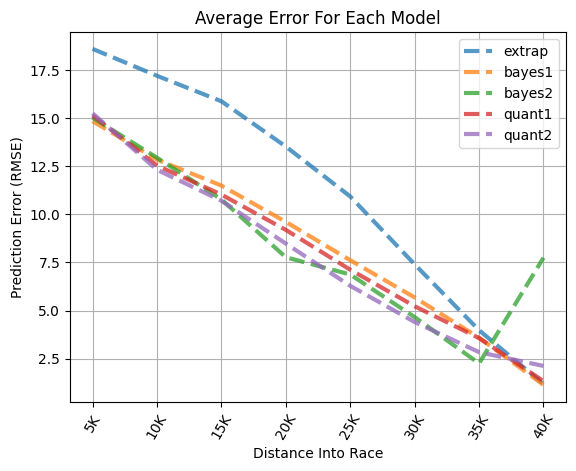

In [3]:
labels = ["extrap", "bayes1", "bayes2", "quant1", "quant2"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table = test.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table)
table.plot(label=table.columns,  style=styles, linewidth=3, grid=True, alpha=0.75)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
plt.savefig("analysis/all_errors.png", bbox_inches="tight")

In [4]:
def add_intervals_to_test(test_data, b1, b2, q1, q2):
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / test_data["finish"]
        b11, b12 = np.percentile(b1, [lower, upper], axis=1)
        test_data[f"bayes1-lower{conf}"] = b11
        test_data[f"bayes1-upper{conf}"] = b12
        test_data[f"bayes1-size{conf}"] = b12 - b11
        test_data[f"bayes1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(b2, [lower, upper], axis=1)
        test_data[f"bayes2-lower{conf}"] = b21
        test_data[f"bayes2-upper{conf}"] = b22
        test_data[f"bayes2-size{conf}"] = b22 - b21
        test_data[f"bayes2-in{conf}"] = (test_true < b22) & (test_true > b21)

        q11, q12 = get_quants(train, test, formula="finish ~ total_pace + dist2", quantiles=[lower, upper])
        test_data[f"quant1-lower{conf}"] = q11
        test_data[f"quant1-upper{conf}"] = q12
        test_data[f"quant1-size{conf}"] = q12 - q11
        test_data[f"quant1-in{conf}"] = (test_true < q12) & (test_true > q11)

        q21, q22 = get_quants(train, test, formula="finish ~ total_pace + curr_pace + dist2", quantiles=[lower, upper])
        test_data[f"quant2-lower{conf}"] = q21
        test_data[f"quant2-upper{conf}"] = q22
        test_data[f"quant2-size{conf}"] = q22 - q21
        test_data[f"quant2-in{conf}"] = (test_true < q22) & (test_true > q21)

    return test_data

test = add_intervals_to_test(test, b1, b2, q1, q2)

(0.0, 1.0)

<Figure size 4000x4000 with 0 Axes>

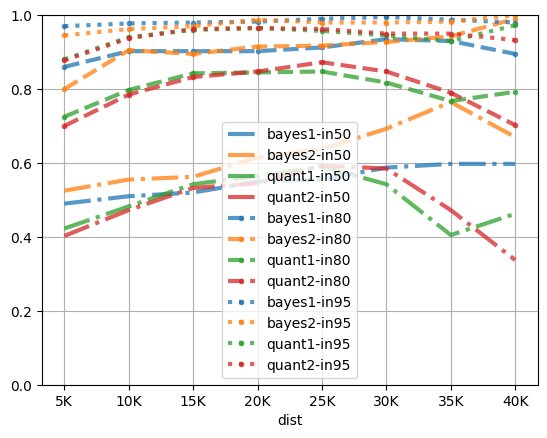

In [9]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-in{conf}", f"bayes2-in{conf}", f"quant1-in{conf}", f"quant2-in{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    # print(table)
    tables.append(table)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 4 + ["--."] * 4 + [":."] * 4 , linewidth=3, grid=True, alpha=0.75, color=colors)
plt.ylim(0, 1) 
    # break
# table

      bayes1-size80  bayes2-size80  quant1-size80  quant2-size80
dist                                                            
5K        43.676928      33.347631      46.089130      44.052024
10K       39.333338      37.431795      39.004126      36.778385
15K       35.645616      32.355372      32.429111      30.343560
20K       31.558781      27.258070      26.352546      24.998269
25K       27.225568      22.053037      20.433284      19.312126
30K       21.278001      15.488081      14.778889      15.232312
35K       13.484422       9.145648       9.147904       9.862144
40K        3.869649      37.132152       3.826591       4.059217
      bayes1-size95  bayes2-size95  quant1-size95  quant2-size95
dist                                                            
5K        67.621774      51.379981      77.703952      74.291932
10K       60.810120      57.801614      65.618605      61.959040
15K       54.878433      49.823623      54.658167      51.315159
20K       48.541504      

<Figure size 3000x2000 with 0 Axes>

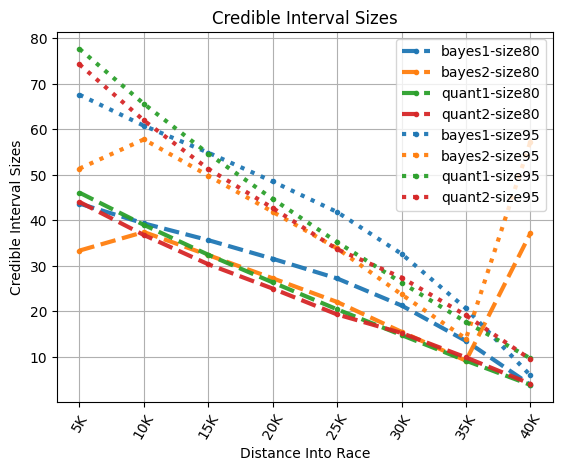

In [15]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] * 2
tables = []
for conf, style in [
    # (50, "-."), 
    (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-size{conf}", f"bayes2-size{conf}", f"quant1-size{conf}", f"quant2-size{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    print(table)
    tables.append(table)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 4 + [":."] * 4 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
# plt.legend(loc="upper center")
# plt.savefig("analysis/all_errors.png", bbox_inches="tight")

In [160]:
table[:]

,bayes1-in95,bayes2-in95,quant1-in95,quant2-in95
dist,,,,
5K,0.97250,0.93900,0.91950,0.91150
10K,0.97950,0.97550,0.95875,0.95725
15K,0.98150,0.97250,0.96600,0.96450
20K,0.98125,0.97375,0.96100,0.96250
25K,0.98350,0.97700,0.96275,0.96725
30K,0.98400,0.97300,0.94225,0.95125
35K,0.98150,0.97425,0.92050,0.93625
40K,0.97750,0.99950,0.96175,0.92900


In [7]:
import arviz as az

array([[<Axes: title={'center': 'b_0'}>, <Axes: title={'center': 'b_0'}>],
       [<Axes: title={'center': 'b_1'}>, <Axes: title={'center': 'b_1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

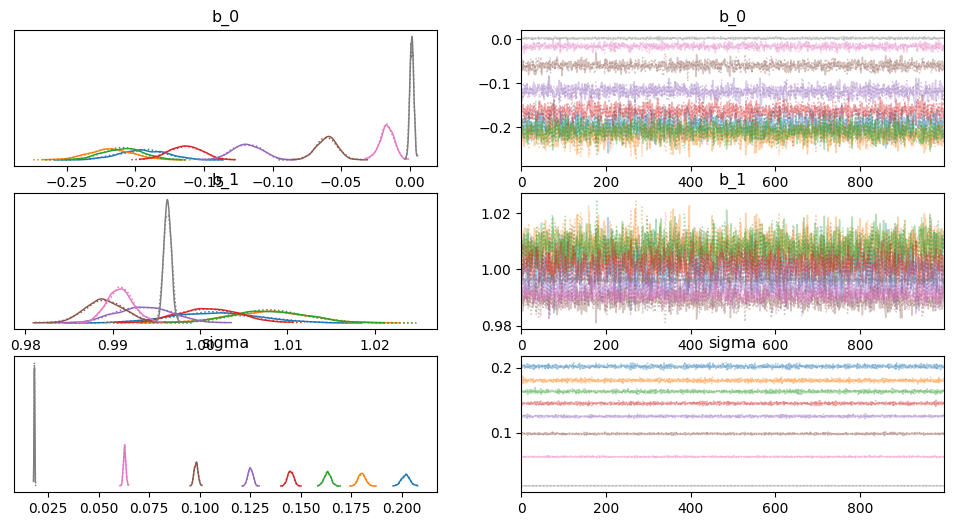

In [209]:

az.plot_trace(trace1)

array([[<Axes: title={'center': 'b_0'}>, <Axes: title={'center': 'b_0'}>],
       [<Axes: title={'center': 'b_1'}>, <Axes: title={'center': 'b_1'}>],
       [<Axes: title={'center': 'b_2'}>, <Axes: title={'center': 'b_2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

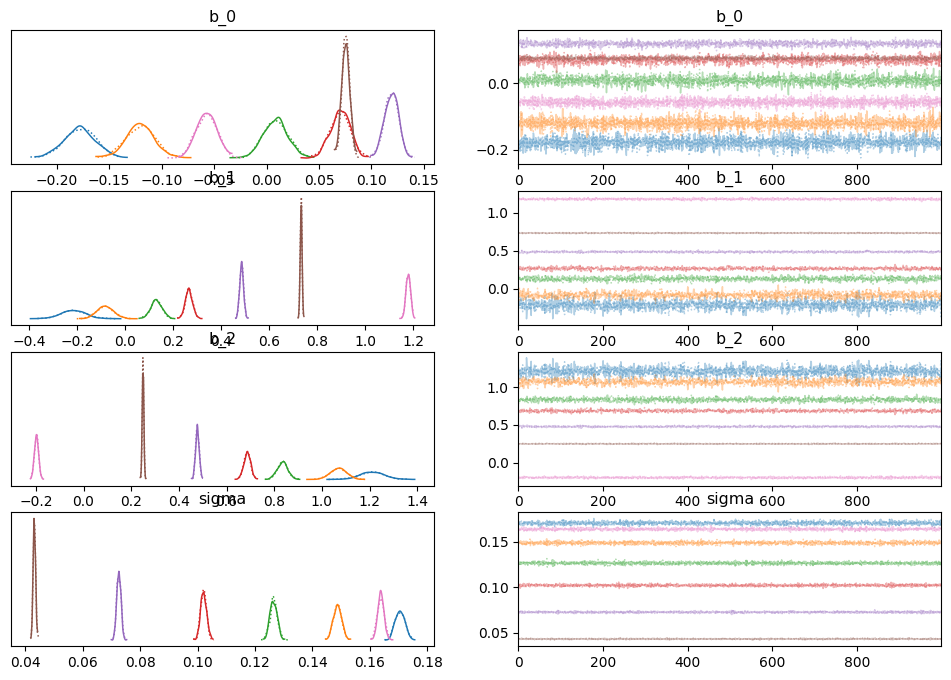

In [210]:
az.plot_trace(trace2)

In [211]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0[5K],-0.195,0.018,-0.228,-0.162,0.0,0.0,1566.0,1377.0,1.00
b_0[10K],-0.218,0.017,-0.248,-0.187,0.0,0.0,1192.0,1124.0,1.00
b_0[15K],-0.209,0.015,-0.235,-0.180,0.0,0.0,1621.0,1518.0,1.00
b_0[20K],-0.164,0.012,-0.188,-0.142,0.0,0.0,1210.0,1060.0,1.00
b_0[25K],-0.119,0.011,-0.139,-0.100,0.0,0.0,1261.0,1422.0,1.00
b_0[30K],-0.060,0.008,-0.076,-0.046,0.0,0.0,1339.0,1485.0,1.00
b_0[35K],-0.017,0.005,-0.027,-0.008,0.0,0.0,1688.0,1443.0,1.00
b_0[40K],0.001,0.001,-0.001,0.004,0.0,0.0,1039.0,988.0,1.00
b_1[5K],1.002,0.005,0.992,1.011,0.0,0.0,1516.0,1438.0,1.00
b_1[10K],1.008,0.005,0.999,1.016,0.0,0.0,1182.0,1220.0,1.00


In [212]:
az.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0[10K],-0.178,0.015,-0.206,-0.150,0.000,0.000,2981.0,1687.0,1.00
b_0[15K],-0.120,0.014,-0.146,-0.095,0.000,0.000,3248.0,1475.0,1.01
b_0[20K],0.009,0.012,-0.014,0.029,0.000,0.000,1812.0,1256.0,1.00
b_0[25K],0.070,0.009,0.052,0.087,0.000,0.000,2033.0,1337.0,1.00
b_0[30K],0.119,0.007,0.107,0.131,0.000,0.000,1726.0,1251.0,1.00
b_0[35K],0.076,0.004,0.069,0.083,0.000,0.000,1976.0,1313.0,1.00
b_0[40K],-0.057,0.010,-0.075,-0.038,0.000,0.000,2817.0,1584.0,1.00
b_1[10K],-0.214,0.053,-0.307,-0.107,0.001,0.001,1735.0,1213.0,1.00
b_1[15K],-0.083,0.035,-0.152,-0.019,0.001,0.001,1283.0,1428.0,1.00
b_1[20K],0.130,0.023,0.085,0.174,0.001,0.000,1278.0,1178.0,1.00


In [13]:
from bayes_models.model2 import LinearModel as LinearModel2
sampler_config1 = {"draws": 1_000,"tune": 1_000,"chains": 2,"target_accept": 0.95}
sampler_config2 ={'draws': 1_000, 'tune': 1_000, 'chains': 2, 'target_accept': 0.95}
model_config1 = {"b0_mu_prior": 0, "b0_sigma_prior": 5, "b1_mu_prior": 0, "b1_sigma_prior": 5, "sigma_beta_prior": 2}
    
m3 = LinearModel2(model_config=model_config2, sampler_config=sampler_config2)


In [25]:
model_config2 = {"b0_mu_prior": 0,  "b0_sigma_prior": 5,  "b1_mu_prior": 0,  "b1_sigma_prior": 5, 
                    "b2_mu_prior": 0,  "b2_sigma_prior": 5,  "sigma_beta_prior": 2, "idata_kwargs": {'log_likelihood':True, "method": "advi"},}
m3 = LinearModel2(model_config=model_config2, sampler_config=sampler_config2)
t3 = m3.fit(train, train["finish"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b_0, b_1, b_2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 921 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [b_0, b_1, b_2, sigma, y]
Sampling: [y]


array([[<Axes: title={'center': 'b_0'}>, <Axes: title={'center': 'b_0'}>],
       [<Axes: title={'center': 'b_1'}>, <Axes: title={'center': 'b_1'}>],
       [<Axes: title={'center': 'b_2'}>, <Axes: title={'center': 'b_2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

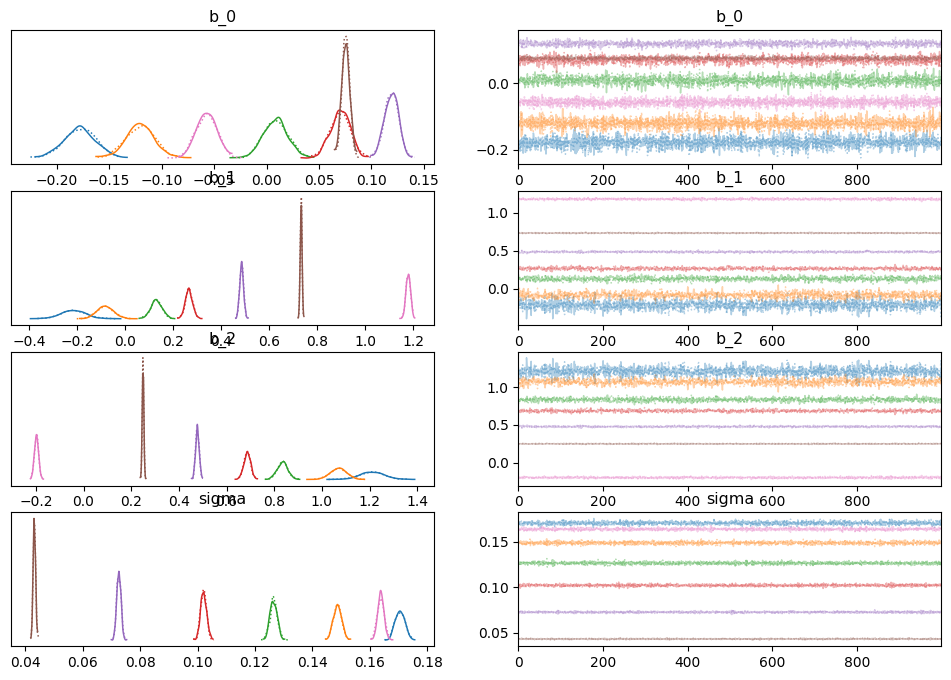

In [12]:
az.plot_trace(trace2)